## $\S$ 4.4.2. Example: South African Heart Disease

The data in FIGURE 4.12 are a subset of the Coronary Risk-Factor Study (CORIS) baseline survey, carried out in three rural areas of the Western Cape, South Africa (Rousseauw et al., 1983). These data are described in more detail in Hastie and Tibshirani (1987).

In [1]:
"""FIGURE 4.12. A scatterplot matrix of the South African heart desease
data.

"""
import pandas as pd
import scipy
import scipy.linalg
import matplotlib.pyplot as plt

In [2]:
df_saheart = pd.read_csv('../data/heart/SAheart.data', index_col=0)
print('A pandas DataFrame of size {} x {} '
      'has been loaded.'.format(*df_saheart.shape))
df_saheart.head()

A pandas DataFrame of size 462 x 10 has been loaded.


,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
row.names,,,,,,,,,,
1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [3]:
df_saheart.pop('adiposity')
df_saheart.pop('typea')  # The textbook doesn't use them
df_y = df_saheart.pop('chd')

In [4]:
df_saheart['famhist'] = df_saheart['famhist'].map({'Present': 1,
                                                   'Absent': 0})
df_saheart.describe()

,sbp,tobacco,ldl,famhist,obesity,alcohol,age
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,0.415584,26.044113,17.044394,42.816017
std,20.496317,4.593024,2.070909,0.493357,4.213680,24.481059,14.608956
min,101.000000,0.000000,0.980000,0.000000,14.700000,0.000000,15.000000
25%,124.000000,0.052500,3.282500,0.000000,22.985000,0.510000,31.000000
50%,134.000000,2.000000,4.340000,0.000000,25.805000,7.510000,45.000000
75%,148.000000,5.500000,5.790000,1.000000,28.497500,23.892500,55.000000
max,218.000000,31.200000,15.330000,1.000000,46.580000,147.190000,64.000000


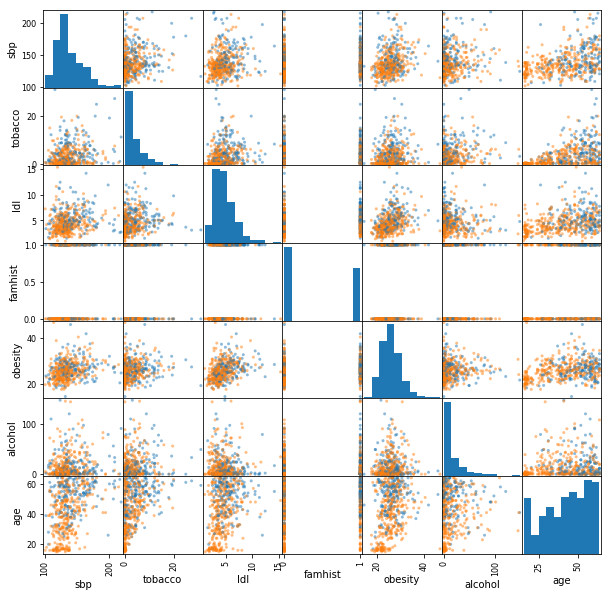

In [5]:
colors = df_y.apply(lambda y: 'C0' if y else 'C1')
pd.plotting.scatter_matrix(df_saheart, c=colors, figsize=(10, 10))
plt.show()

We fit a logistic-regression model by maximum likelihood, giving the results shown in TABLE 4.2.

In [6]:
"""TABLE 4.2. Results from a logistic regression fit to the South African
heart disease data
"""
mat_X = df_saheart.as_matrix()
size_training, size_predictor = mat_X.shape
size_beta = size_predictor + 1

vec_y = df_y.as_matrix()
mat_1X = scipy.hstack((scipy.ones((size_training, 1)), mat_X))


def fvec_p(mat_x:scipy.ndarray, vec_beta:scipy.ndarray)->scipy.ndarray:
    num = scipy.exp(mat_x@vec_beta)
    return num/(num+1)


def fdiag_W(mat_x:scipy.ndarray, vec_beta:scipy.ndarray)->scipy.ndarray:
    vec_p = fvec_p(mat_x, vec_beta)
    return vec_p*(1-vec_p)

In [7]:
vec_beta_old = scipy.zeros(size_beta)
vec_increment = scipy.ones(size_beta)
while (vec_increment**2).sum() > 1e-8:
    vec_p = fvec_p(mat_1X, vec_beta_old)
    gradient = mat_1X.T @ (vec_y-vec_p)
    hessian = mat_1X.T @ scipy.diag(fdiag_W(mat_1X, vec_beta_old)) @ mat_1X
    vec_increment = scipy.linalg.solve(hessian, gradient)
    vec_beta_new = vec_beta_old + vec_increment
    vec_beta_old = vec_beta_new.copy()

[ -4.12959973e+00   5.76067669e-03   7.95256307e-02   1.84779334e-01
   9.39185489e-01  -3.45434338e-02   6.06501726e-04   4.25412099e-02]


In [10]:
"""I have no idea where the Std. Error comes from..."""
print('{0:>15} {1:>15} {2:>15} {3:>15}'.format('Term', 'Coefficient',
                                               'Std. Error', 'Z Score'))
print('-'*64)
table_term = ['intercept'] + list(df_saheart.columns)
for term, coeff in zip(table_term, vec_beta_new):
    print('{0:>15} {1:>15f}'.format(term, coeff))

           Term     Coefficient      Std. Error         Z Score
----------------------------------------------------------------
      intercept       -4.129600
            sbp        0.005761
        tobacco        0.079526
            ldl        0.184779
        famhist        0.939185
        obesity       -0.034543
        alcohol        0.000607
            age        0.042541


This summary includes $Z$ scores ($\frac{\text{coefficients}}{\text{stderr}}$); a nonsignificant $Z$ score suggests a coefficient can be dropped from the model. Each of these correspond formally to a test of the null hypothesis that the coefficient in question is zero, while all the others are not (a.k.a. the Wald test).

### Correlations between predictors

There are some surprises in this table, which must be interpreted with caution. Systolic blood pressure ($\textsf{sbp}$) is not significant! Nor is $\textsf{obesity}$, and its sign is negative.

This confusion is a result of the correlation between the set of predictors. On their own, both $\textsf{sbp}$ and $\textsf{obesity}$ are significant, However, in the presense of many other correlated variables, thery are no longer needed (and can even get a negative sign).

### Model selection

At this stage the analyst might do some model selection; find a subset of the variables that are sufficient for explaining their joint effect on the prevalence of the response ($\textsf{chd}$).

One way to proceed by is to drop the least significant coefficient, and refit the model. This is done repeatedly until no further terms can be dropped. This gave the model shown in TABLE 4.3.

A better but time-consuming strategy is to refit each of the models with one variable removed, and then perform an *analysis of deviance* to decide which variable to exclude.

The residual deviance of a fitted model is

\begin{equation}
\text{residual deviance}(\beta) = -2\text{ log-likelihood}(\beta),
\end{equation}

and the deviance between two models is the difference of their residual deviance, as

\begin{equation}
\text{deviance}(\beta^{(1)}, \beta^{(2)}) = \text{residual deviance}(\beta^{(1)}) - \text{residual deviance}(\beta^{(2)}).
\end{equation}

This strategy gave the same final model as TABLE 4.3.

### Interpretation of a coefficient

How does one interpret $\textsf{tobacco}$ coefficient of $0.081$ ($\text{Std. Error} = 0.026$), for example?

An increase of $1\text{kg}$ in lifetime tobacco usage accounts for an increase in the odds of coronary heart disease of $\exp(0.081)=1.084$ or $8.4\%$.

Incorporating the standard error we get an approximate $95\%$ confidence interval of

\begin{equation}
\exp(0.081 \pm 2\times 0.026) = (1.03, 1.14).
\end{equation}

We see that some of the variables have nonlinear effects, and when modeled appropriately, are not excluded from the model.